In [11]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')
# Import data manipulation libraries
import pandas as pd
import numpy as np
from pprint import pprint
from collections import OrderedDict
from numpy.linalg import multi_dot
from scipy import stats
from tabulate import tabulate
import yfinance as yf

# Import plotly express
import plotly.express as px
px.defaults.width, px.defaults.height = 1000, 600

# Set precision
pd.set_option('display.precision', 4)

### 0.1 Data Retrieval

In [12]:
# Import & Initialize database
import sqlalchemy
engine = sqlalchemy.create_engine('sqlite:///India')

In [13]:
# We get data from Wikipedia, like Lab 1:
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2].Symbol.to_list()

# Use some list comprehension magic:
data = [yf.download(symbol+'.NS', start="2019-01-01", end="2023-12-31", progress=False).reset_index()
        for symbol in nifty50]

# And we save it to our SQL db
for frame, symbol in zip(data, nifty50):
    frame.to_sql(symbol, engine, if_exists='replace', index=False)

In [14]:
# Specify assets / stocks
assets = sorted(['ICICIBANK', 'ITC', 'RELIANCE', 'TCS', 'ASIANPAINT'])
print(assets)

['ASIANPAINT', 'ICICIBANK', 'ITC', 'RELIANCE', 'TCS']


In [15]:
# Query close price from database
# Refer lab 3 and 1 for further details
df = pd.DataFrame()
for asset in assets:
    df1 = pd.read_sql_query(f'SELECT Date, Close FROM {asset}', engine, index_col='Date')
    df1.columns = [asset]
    df = pd.concat([df, df1], axis=1)
# View dataframe
df

,ASIANPAINT,ICICIBANK,ITC,RELIANCE,TCS
Date,,,,,
2019-01-01 00:00:00.000000,1371.5500,363.75,282.70,1024.9669,1902.8000
2019-01-02 00:00:00.000000,1383.3000,364.60,280.60,1011.6177,1923.3000
2019-01-03 00:00:00.000000,1388.3000,363.25,278.85,999.1371,1899.9500
2019-01-04 00:00:00.000000,1385.8500,365.20,280.95,1004.5316,1876.8500
2019-01-07 00:00:00.000000,1396.0000,367.70,281.65,1010.1091,1897.9000
...,...,...,...,...,...
2023-12-22 00:00:00.000000,3341.3000,994.30,455.20,2565.0500,3824.0000
2023-12-26 00:00:00.000000,3383.3501,995.10,456.45,2578.0500,3795.5500
2023-12-27 00:00:00.000000,3404.4500,1002.25,457.10,2586.8501,3811.2000


In [16]:
# Calculate daily returns
returns = df.pct_change().dropna()
returns.head()

,ASIANPAINT,ICICIBANK,ITC,RELIANCE,TCS
Date,,,,,
2019-01-02 00:00:00.000000,0.0086,0.0023,-0.0074,-1.3024e-02,0.0108
2019-01-03 00:00:00.000000,0.0036,-0.0037,-0.0062,-1.2337e-02,-0.0121
2019-01-04 00:00:00.000000,-0.0018,0.0054,0.0075,5.3992e-03,-0.0122
2019-01-07 00:00:00.000000,0.0073,0.0068,0.0025,5.5523e-03,0.0112
2019-01-08 00:00:00.000000,0.0038,0.0339,0.0092,-9.0516e-05,-0.0023


## Value at Risk

### 1.1 Parametric VaR

We use the variance-covariance method to calculate the VaR for 90%, 95% & 99%. We recall that the VaR is $VaR = position \cdot (\mu - z \sigma)$ for $z=1.29, 1.64, 2.33$ and the return $\mu$, volatility $\sigma$

In [17]:
# Stock returns for ICICIBank
stockreturn = returns['ICICIBANK']
# Calculate mean and standard deviation
mean = np.mean(stockreturn)
stdev = np.std(stockreturn)
# Calculate VaR at difference confidence level
VaR_90 = stats.norm.ppf(1-0.90,mean,stdev)
VaR_95 = stats.norm.ppf(1-0.95,mean,stdev)
VaR_99 = stats.norm.ppf(1-0.99,mean,stdev)

In [19]:
# Number of stdev from the mean
stats.norm.ppf(0.01)

-2.3263478740408408

In [21]:
# Ouput results in tabular format
table = [['90%', VaR_90],['95%', VaR_95],['99%', VaR_99] ]
header = ['Confidence Level', 'Value At Risk']

# Nice
print(tabulate(table,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0255135
95%                      -0.033039
99%                      -0.0471556


### 1.2 Historical VaR

Recall that asset returns tend to not follow normal distributions. We now use a quantile-based method to find the VaR for the given confidence levels:

In [22]:
# Use quantile function for Historical VaR
hVaR_90 = returns['ICICIBANK'].quantile(0.10)
hVaR_95 = returns['ICICIBANK'].quantile(0.05)
hVaR_99 = returns['ICICIBANK'].quantile(0.01)

In [23]:
# Ouput results in tabular format
htable = [['90%', hVaR_90],['95%', hVaR_95],['99%', hVaR_99]]
print(tabulate(htable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0185134
95%                      -0.0273168
99%                      -0.0517425


Note how they definitely differ from the parametric VaR, but with no particular pattern. If the underlying distributions of the returns were i.i.d normal, then the historical VaR should converge to the parametric VaR.

### 1.3 Monte Carlo VaR

Everyone's favourite, just assume the returns follow i.i.d normals and simulate a bunch of stock returns:

In [24]:
# Set seed for reproducibility
np.random.seed(42)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)
# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns,1)

In [25]:
# Ouput results in tabular format
mctable = [['90%', MCVaR_90],['95%', MCVaR_95],['99%', MCVaR_99]]
print(tabulate(mctable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0252617
95%                      -0.0323925
99%                      -0.0479152


As expected, it looks close to the parametric VaR.

### 1.4 Normality Test

Now we actually confirm whether our returns are normally distributed.

#### Shapiro-Wilk
The null hypothesis here is that the stock's daily returns follow a normal distribution. If the $p$-value is less than our significance level, then we reject the null hypothesis: We believe there significantly many returns follow non-normal distributions

In [34]:
# normality test
stats.shapiro(stockreturn)

ShapiroResult(statistic=0.8966503739356995, pvalue=5.122255761683277e-28)

The $p$-value is low, so we reject the null hypothesis.

#### Anderson-Darling

Another goodness-of-fit test. This one is more general, and tends to display worse performance than the Shapiro-Wilk test:

In [32]:
# normality test
stats.anderson(stockreturn)

AndersonResult(statistic=22.100717994338993, critical_values=array([0.574, 0.654, 0.784, 0.915, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.001032777728134385, scale=0.02072257914283287)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

The statistic is absurdly high, way past the critical values, definitely reject the null-hypothesis

#### Histogram

We have a look at the returns:

In [33]:
# Plot histogram
px.histogram(returns,
histnorm='probability density',
title='Histogram of Returns',
barmode='relative')

### 1.5 Modified VaR

Now that we have confirmation the returns are not non-normal, skewness and kurtosis have an effect on VaR. We will have to use the Cornish-Fisher VaR (Specifics involve cumulants and Hermite polynomials, will gloss over for now).

Here, we modify $z$ in the previous VaR formula to this:

$$
t = z + \frac{1}{6}(z^2-1)s + \frac{1}{24}(z^3 - 3z)k - \frac{1}{36}(2z^3 - 5z)s^2
$$

Where $z$ is as before, $s$ is skewness and $k$ is kurtosis. We then plug in to the previous formula to get:

$$
mVaR = position \cdot (\mu - t \sigma)
$$

In [35]:
# First four moments
dist = OrderedDict({
'Mean': np.mean(returns['ICICIBANK']),
'Variance': np.std(returns['ICICIBANK']),
'Skew': stats.skew(returns['ICICIBANK']),
'Kurtosis': stats.kurtosis(returns['ICICIBANK'])
})
pprint(dist)

OrderedDict([('Mean', 0.001032777728134385),
             ('Variance', 0.020714180934122074),
             ('Skew', -0.2560619763376188),
             ('Kurtosis', 10.164296193565145)])


In [36]:
# Specify params for modified VaR
z = abs(stats.norm.ppf(0.01))
s = stats.skew(stockreturn)
k = stats.kurtosis(stockreturn)
t = z+1/6*(z**2-1)*s+1/24*(z**3-3*z)*k-1/36*(2*z**3-5*z)*s**2
# Calculate VaR at difference confidence level
mVaR_99 = (mean-t*stdev)
mVaR_99

-0.09196713308208161

Note that with skewness and kurtosis involved, the $mVaR$ is twice as bad as the $VaR$ we got.

### 1.6 Scaling Var

Now we consider VaR over a longer period, say 5 days. Recall that we find this by scaling by the square root of time (as VaR is a measure deriving from standard deviation).

$$
VaR = position \cdot (\mu - z \sigma)\sqrt{T}
$$

In [37]:
# VaR Scaling
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

In [38]:
# Ouput results in tabular format
ftable = [['90%', f_VaR_90],['95%', f_VaR_95],['99%', f_VaR_99] ]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable,headers=fheader))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                     -0.05705
95%                                     -0.0738775
99%                                     -0.105443


In [39]:
# Plot Scaled VaR
sVaR = pd.DataFrame([-100*VaR_99*np.sqrt(x) for x in range(100)], columns=['ScaledVaR'])
px.scatter(sVaR, sVaR.index,'ScaledVaR',title='Scaled VaR', labels={'index' : 'Horizon'})

### 1.7 Expected Shortfall

We now consider the conditional Value at Risk, i.e an estimate of the expected shortfall sustained in the absolute worst (1-x%) of scenarios. We recall it's the average loss condiitoned on the return being worse than the VaR:

$$
CVaR = \mathbb{E}[R \mid R \leq CVaR_{cl}] \approx \frac{1}{N_{cl}}\sum_{i=1}^{N_{cl}} R_i \cdot \mathbb{P}(R_i \mid R \leq hVaR_{cl})
$$

Where $R_\cdot$ are returns, $hVaR$ is historical VaR, $cl$ is the confidence level and $N_{cl}$ is the number of returns less than $hVaR_{cl}$.

In [40]:
# Calculate CVar
CVaR_90 = returns['ICICIBANK'][returns['ICICIBANK']<=hVaR_90].mean()
CVaR_95 = returns['ICICIBANK'][returns['ICICIBANK']<=hVaR_95].mean()
CVaR_99 = returns['ICICIBANK'][returns['ICICIBANK']<=hVaR_99].mean()

In [41]:
# Ouput results in tabular format
ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0350783
95%                                  -0.0480382
99%                                  -0.0863165


### 1.8 Portfolio VaR

Now that we know the returns & volatilities of all the assets in the portfolio, we can get the portfolio VaR. We do so by finding the mean/standard deviation of the portfolio and use our usual methods:

In [42]:
# Weights from Minimum Variance Portfolio
wts = np.array([2.553e-01, 4.434e-02, 2.944e-01, 8.664e-02, 3.193e-01])
# Portfolio mean returns and volatility
port_mean = wts.T @ returns.mean()
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
pVaR = stats.norm.ppf(1-0.99, port_mean, port_stdev)
print(f"Mean: {port_mean}, Stdev: {port_stdev}, pVaR: {pVaR}")

Mean: 0.0007255033614542081, Stdev: 0.011289144312598084, pVaR: -0.025536973509898593


## GARCH

### Volatilities

We know volatilites are definitely not constant, especially with phenomena like volatility clustering. We then turn to methods of estimation. The easiest (and naive) method is just an application of the Law of Large Numbers. Assuming mean returns are 0 ($\bar{u} = 0$), we can estimate the sample volatility at day $n$, $\sigma_n$ as:

$$
\sigma_n^2 = \frac{1}{m} \sum_{i=1}^m u_{n-i}^2
$$

Where $u$ are returns.

### ARCH

We notice some things about volatilities:

1. They are mean-reverting;
2. Large returns will heavily affect the sample volatility, until it drops out of the rolling sample.

We then adopt the weighting schemes, to midigate the above:

$$
\sigma_n^2 = \omega + \sum_{i=1}^m \alpha_i u_{n-i}^2
$$

Where $\omega = \gamma \bar{\sigma}^2$ for some $\gamma \geq 0$ and $\alpha_i \geq 0$. There is also the added requirement that the polynomial $1 - \alpha_1 z - \cdots - \alpha_{p-1}z^{p-1} - \alpha_p z^p = 0 $ has (complex) roots all outside of the unit circle, but we won't get too much into this. For now, we can just assume that all the weights add up to 1.

### GARCH

We can generalize further to also consider previous variances, i.e the MA part. This nets us the Generalized ARCH or GARCH model:

$$
\sigma_n^2 = \omega + \sum_{i=1}^p \alpha_iu_{n-i}^2 + \sum_{i=1}^q \beta_i \sigma_{n-1^2}
$$

Where $p,q$ are lag lengths.

In the simplified case of GARCH(1,1), we have:

$$
\sigma_n^2 = \omega + \alpha u_{n-1}^2 + \beta \sigma_{n-1}^2
$$

Here, $\alpha + \beta < 1$ and $\gamma + \alpha + \beta = 1$ are necessary to prevent the long-run variance $\frac{\omega}{1 - \alpha - \beta}$ from being negative.

To get the right $\omega, \alpha, \beta$, we need to maximize the likelihood function.

### 2.1 ARCH Toolbox

Turns out there's an ARCH library: `arch`

In [43]:
# Import ARCH library
from arch import arch_model

In [45]:
# Mean zero
g1 = arch_model(np.array(stockreturn), vol='GARCH', mean='Zero', p=1, q=1, dist='normal')
model = g1.fit() 

Iteration:      1,   Func. Count:      4,   Neg. LLF: -3268.8448758088307
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3268.844877041982
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


In [46]:
# Model output
print(model)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3268.84
Distribution:                  Normal   AIC:                          -6531.69
Method:            Maximum Likelihood   BIC:                          -6516.34
                                        No. Observations:                 1234
Date:                Thu, Mar 07 2024   Df Residuals:                     1234
Time:                        01:53:45   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.6029e-06  3.637e-09   2365.676      0.000 [8.

In [47]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3268.84
Distribution:                  Normal   AIC:                          -6531.69
Method:            Maximum Likelihood   BIC:                          -6516.34
                                        No. Observations:                 1234
Date:                Thu, Mar 07 2024   Df Residuals:                     1234
Time:                        01:53:45   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.6029e-06  3.637e-09   2365.676      0.000 [8.596e-06,8.610e-06]
alpha[1]       0.1000  4.373e-02      2.287  2.222e-02   [1.429e-02,  0.186]
beta[1]        0.8800  3.024e-02     29.104 3.177e-186     [  0.821,  0.939]
============================================================================

Covariance estimator: robust
"""

In [48]:
# Model params
model.params

omega       8.6029e-06
alpha[1]    1.0000e-01
beta[1]     8.8000e-01
Name: params, dtype: float64

In [49]:
# Model Confidence Interval
model.conf_int(alpha=0.01)

,lower,upper
omega,8.5935e-06,8.6122e-06
alpha[1],-1.2648e-02,2.1265e-01
beta[1],8.0212e-01,9.5788e-01


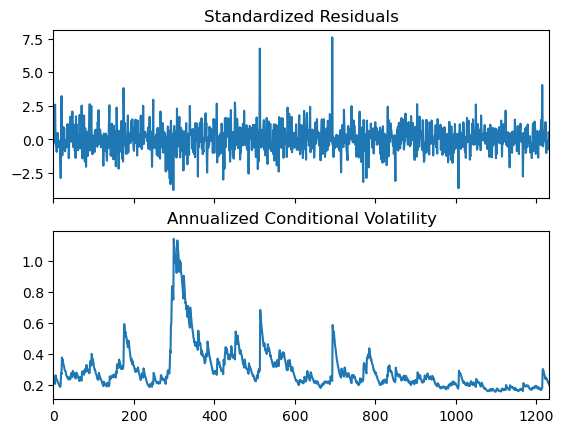

In [50]:
# Plot annualised vol
fig = model.plot(annualize='D')

In [51]:
# Forecast for next 5 days
model_forecast = model.forecast(horizon=60)
# Plot forecasted volatility
fdf = pd.DataFrame(np.sqrt(model_forecast.variance.dropna().T *252)*100)
fdf.columns = ['Cond_Vol']
px.scatter(fdf, fdf.index, 'Cond_Vol', labels={'index':'Horizon'}, title='GARCH Volatility Forecast')